In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import os

In [2]:
data_train_val = pd.read_csv('../Khaairi/Data/train_val.csv')
data_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29949 entries, 0 to 29948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  29949 non-null  int64 
 1   pixel    29949 non-null  object
dtypes: int64(1), object(1)
memory usage: 468.1+ KB


In [3]:
data_test = pd.read_csv('../Khaairi/Data/test.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3328 non-null   int64 
 1   pixel    3328 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.1+ KB


In [4]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_val = train_test_split(data_train_val, test_size=0.1, stratify=data_train_val['emotion'], random_state=42)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26954
Validation set size: 2995
Test set size: 3328


In [5]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(data_train)
val_dataset = Dataset.from_pandas(data_val)
test_dataset = Dataset.from_pandas(data_test)

# Membuat DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

/home/ilkom/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['emotion', 'pixel', '__index_level_0__'],
        num_rows: 26954
    })
    validation: Dataset({
        features: ['emotion', 'pixel', '__index_level_0__'],
        num_rows: 2995
    })
    test: Dataset({
        features: ['emotion', 'pixel'],
        num_rows: 3328
    })
})


In [6]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [7]:
from transformers import AutoImageProcessor, ViTForImageClassification

processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from PIL import Image

def string_to_image(image_pixels):
    # Ubah string piksel menjadi array numpy
    pixels = np.array([int(pixel) for pixel in image_pixels.split()], dtype=np.uint8)
    # Bentuk ulang array menjadi gambar 48x48 (sesuaikan dengan resolusi gambar Anda)
    image = pixels.reshape(48, 48)
    # Ubah menjadi gambar RGB
    image = Image.fromarray(image).convert('RGB')
    return image

In [9]:
def transforms(batch):
    # Ubah string piksel menjadi gambar RGB
    batch['pixel'] = [string_to_image(x) for x in batch['pixel']]
    # Proses gambar dengan tokenizer/processor
    inputs = processor(batch['pixel'], return_tensors='pt')
    # Buat label yang sesuai dengan ID label
    inputs['labels'] = batch['emotion']
    return inputs

In [10]:
processed_dataset = dataset.with_transform(transforms)

In [11]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [12]:
import evaluate

# Memuat metrik
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

# Fungsi untuk menghitung metrik
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    # Menghitung accuracy
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    # Menghitung F1 score
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')

    # Menggabungkan kedua metrik
    metrics = {
        'accuracy': accuracy_score['accuracy'],
        'f1': f1_score['f1']
    }

    return metrics

In [13]:
vit = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
vit

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
for name,p in vit.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [17]:
num_params = sum([p.numel() for p in vit.parameters()])
trainable_params = sum([p.numel() for p in vit.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,804,039 | trainable_params = 5,383


In [20]:
from transformers import TrainerCallback, TrainingArguments, Trainer

# Callback untuk menyimpan model terbaik dan loss
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, save_path, metric_name='eval_accuracy'):
        super().__init__()
        self.best_metric = -float('inf')  # Menyimpan metrik terbaik
        self.metric_name = metric_name
        self.save_path = save_path
        self.train_losses = []  # Menyimpan training loss per epoch
        self.eval_losses = []   # Menyimpan validation loss per epoch
        self.accuracies = []  # Menyimpan accuracy per epoch
        os.makedirs(self.save_path, exist_ok=True)
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.accuracies.append(metrics['eval_accuracy'])
        # Periksa apakah metrik saat ini lebih baik dari yang terbaik
        if self.metric_name in metrics and metrics[self.metric_name] > self.best_metric:
            self.best_metric = metrics[self.metric_name]
            model_path = os.path.join(self.save_path, "pretrained_freeze_best_model.pt")
            torch.save(kwargs['model'].state_dict(), model_path)
            print(f"Model terbaik disimpan di {model_path} dengan {self.metric_name}: {self.best_metric:.4f}")
    
    def on_epoch_end(self, args, state, control, **kwargs):
        # Ambil training loss dan accuracy dari log_history
        if state.log_history:
            if "loss" in state.log_history[-1]:
                self.train_losses.append(state.log_history[-1]["loss"])

        # Simpan grafik loss
        loss_path = os.path.join(self.save_path, "pretrained_freeze_loss_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Training Loss", marker='o')
        if self.eval_losses:
            plt.plot(range(1, len(self.eval_losses) + 1), self.eval_losses, label="Validation Loss", marker='o')
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_path)
        plt.close()
        print(f"Grafik loss disimpan untuk epoch {state.epoch}")
        
        # Simpan grafik accuracy
        accuracy_path = os.path.join(self.save_path, "pretrained_freeze_accuracy_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, label="Accuracy", marker='o')
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.savefig(accuracy_path)
        plt.close()
        print(f"Grafik accuracy disimpan untuk epoch {state.epoch}")

In [21]:
training_args = TrainingArguments(
    output_dir="../Khaairi/Result",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    num_train_epochs=1000,
    learning_rate=3e-4,
    remove_unused_columns=False,
)

/home/ilkom/.local/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Trainer(
    model=vit,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

/tmp/ipykernel_184696/2079443237.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.209400,1.194695,0.559599,0.551150
2,1.125000,1.139816,0.578631,0.573211
3,1.075500,1.101024,0.600000,0.588602
4,1.035000,1.097259,0.601669,0.594236
5,1.041200,1.089105,0.608347,0.600771
6,1.031000,1.077104,0.605008,0.591175
7,0.992200,1.090714,0.607012,0.599461
8,0.983900,1.071387,0.611352,0.603565
9,1.002600,1.064452,0.608013,0.599923
10,0.976200,1.059667,0.611352,0.604531


Grafik loss disimpan untuk epoch 1.0
Grafik accuracy disimpan untuk epoch 1.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.5596


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.5786


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6000


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 4.0
Grafik accuracy disimpan untuk epoch 4.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6017


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 5.0
Grafik accuracy disimpan untuk epoch 5.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6083


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 6.0
Grafik accuracy disimpan untuk epoch 6.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 7.0
Grafik accuracy disimpan untuk epoch 7.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 8.0
Grafik accuracy disimpan untuk epoch 8.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6114


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 9.0
Grafik accuracy disimpan untuk epoch 9.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 10.0
Grafik accuracy disimpan untuk epoch 10.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 11.0
Grafik accuracy disimpan untuk epoch 11.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6154


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 12.0
Grafik accuracy disimpan untuk epoch 12.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 13.0
Grafik accuracy disimpan untuk epoch 13.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 14.0
Grafik accuracy disimpan untuk epoch 14.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 15.0
Grafik accuracy disimpan untuk epoch 15.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6180


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 16.0
Grafik accuracy disimpan untuk epoch 16.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6220


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 17.0
Grafik accuracy disimpan untuk epoch 17.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 18.0
Grafik accuracy disimpan untuk epoch 18.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 19.0
Grafik accuracy disimpan untuk epoch 19.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 20.0
Grafik accuracy disimpan untuk epoch 20.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 21.0
Grafik accuracy disimpan untuk epoch 21.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 22.0
Grafik accuracy disimpan untuk epoch 22.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 23.0
Grafik accuracy disimpan untuk epoch 23.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 24.0
Grafik accuracy disimpan untuk epoch 24.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6224


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 25.0
Grafik accuracy disimpan untuk epoch 25.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 26.0
Grafik accuracy disimpan untuk epoch 26.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 27.0
Grafik accuracy disimpan untuk epoch 27.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 28.0
Grafik accuracy disimpan untuk epoch 28.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 29.0
Grafik accuracy disimpan untuk epoch 29.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 30.0
Grafik accuracy disimpan untuk epoch 30.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 31.0
Grafik accuracy disimpan untuk epoch 31.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 32.0
Grafik accuracy disimpan untuk epoch 32.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 33.0
Grafik accuracy disimpan untuk epoch 33.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 34.0
Grafik accuracy disimpan untuk epoch 34.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 35.0
Grafik accuracy disimpan untuk epoch 35.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6227


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 36.0
Grafik accuracy disimpan untuk epoch 36.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6237


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 37.0
Grafik accuracy disimpan untuk epoch 37.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 38.0
Grafik accuracy disimpan untuk epoch 38.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 39.0
Grafik accuracy disimpan untuk epoch 39.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 40.0
Grafik accuracy disimpan untuk epoch 40.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 41.0
Grafik accuracy disimpan untuk epoch 41.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 42.0
Grafik accuracy disimpan untuk epoch 42.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 43.0
Grafik accuracy disimpan untuk epoch 43.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 44.0
Grafik accuracy disimpan untuk epoch 44.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 45.0
Grafik accuracy disimpan untuk epoch 45.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 46.0
Grafik accuracy disimpan untuk epoch 46.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 47.0
Grafik accuracy disimpan untuk epoch 47.0
Grafik loss disimpan untuk epoch 48.0
Grafik accuracy disimpan untuk epoch 48.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 49.0
Grafik accuracy disimpan untuk epoch 49.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 50.0
Grafik accuracy disimpan untuk epoch 50.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 51.0
Grafik accuracy disimpan untuk epoch 51.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 52.0
Grafik accuracy disimpan untuk epoch 52.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 53.0
Grafik accuracy disimpan untuk epoch 53.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 54.0
Grafik accuracy disimpan untuk epoch 54.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 55.0
Grafik accuracy disimpan untuk epoch 55.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 56.0
Grafik accuracy disimpan untuk epoch 56.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 57.0
Grafik accuracy disimpan untuk epoch 57.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 58.0
Grafik accuracy disimpan untuk epoch 58.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 59.0
Grafik accuracy disimpan untuk epoch 59.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 60.0
Grafik accuracy disimpan untuk epoch 60.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 61.0
Grafik accuracy disimpan untuk epoch 61.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 62.0
Grafik accuracy disimpan untuk epoch 62.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 63.0
Grafik accuracy disimpan untuk epoch 63.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 64.0
Grafik accuracy disimpan untuk epoch 64.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 65.0
Grafik accuracy disimpan untuk epoch 65.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 66.0
Grafik accuracy disimpan untuk epoch 66.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 67.0
Grafik accuracy disimpan untuk epoch 67.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 68.0
Grafik accuracy disimpan untuk epoch 68.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 69.0
Grafik accuracy disimpan untuk epoch 69.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 70.0
Grafik accuracy disimpan untuk epoch 70.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 71.0
Grafik accuracy disimpan untuk epoch 71.0
Model terbaik disimpan di ../Khaairi/Result/pretrained_freeze_best_model.pt dengan eval_accuracy: 0.6267


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 72.0
Grafik accuracy disimpan untuk epoch 72.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 73.0
Grafik accuracy disimpan untuk epoch 73.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 74.0
Grafik accuracy disimpan untuk epoch 74.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 75.0
Grafik accuracy disimpan untuk epoch 75.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 76.0
Grafik accuracy disimpan untuk epoch 76.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 77.0
Grafik accuracy disimpan untuk epoch 77.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 78.0
Grafik accuracy disimpan untuk epoch 78.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 79.0
Grafik accuracy disimpan untuk epoch 79.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 80.0
Grafik accuracy disimpan untuk epoch 80.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 81.0
Grafik accuracy disimpan untuk epoch 81.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 82.0
Grafik accuracy disimpan untuk epoch 82.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 83.0
Grafik accuracy disimpan untuk epoch 83.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 84.0
Grafik accuracy disimpan untuk epoch 84.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 85.0
Grafik accuracy disimpan untuk epoch 85.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 86.0
Grafik accuracy disimpan untuk epoch 86.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 87.0
Grafik accuracy disimpan untuk epoch 87.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 88.0
Grafik accuracy disimpan untuk epoch 88.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 89.0
Grafik accuracy disimpan untuk epoch 89.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 90.0
Grafik accuracy disimpan untuk epoch 90.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 91.0
Grafik accuracy disimpan untuk epoch 91.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 92.0
Grafik accuracy disimpan untuk epoch 92.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 93.0
Grafik accuracy disimpan untuk epoch 93.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 94.0
Grafik accuracy disimpan untuk epoch 94.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 95.0
Grafik accuracy disimpan untuk epoch 95.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 96.0
Grafik accuracy disimpan untuk epoch 96.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 97.0
Grafik accuracy disimpan untuk epoch 97.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 98.0
Grafik accuracy disimpan untuk epoch 98.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 99.0
Grafik accuracy disimpan untuk epoch 99.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 100.0
Grafik accuracy disimpan untuk epoch 100.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 101.0
Grafik accuracy disimpan untuk epoch 101.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 102.0
Grafik accuracy disimpan untuk epoch 102.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 103.0
Grafik accuracy disimpan untuk epoch 103.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 104.0
Grafik accuracy disimpan untuk epoch 104.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 105.0
Grafik accuracy disimpan untuk epoch 105.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 106.0
Grafik accuracy disimpan untuk epoch 106.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 107.0
Grafik accuracy disimpan untuk epoch 107.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 108.0
Grafik accuracy disimpan untuk epoch 108.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 109.0
Grafik accuracy disimpan untuk epoch 109.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 110.0
Grafik accuracy disimpan untuk epoch 110.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [24]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 1.0948818922042847,
 'eval_accuracy': 0.6063701923076923,
 'eval_f1': 0.5947209128315544}

In [25]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(processed_dataset["test"])

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<Figure size 1200x1000 with 0 Axes>

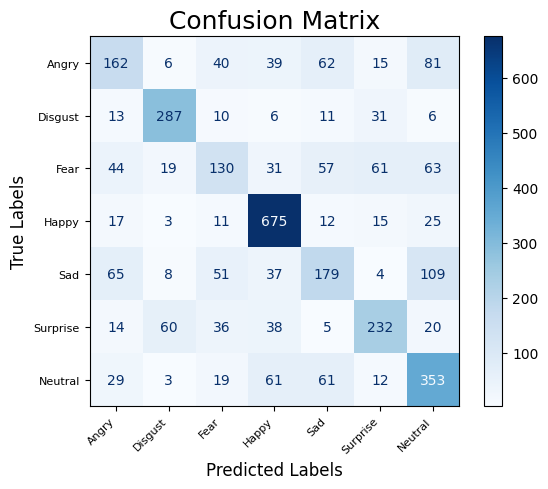

In [26]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()

In [ ]:
vit2 = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

In [ ]:
# Load state_dict
model_path = "../Khaairi/Result/pretrained_best_model.pt"
vit2.load_state_dict(torch.load(model_path))

In [ ]:
trainer = Trainer(
    model=vit2,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

In [ ]:
trainer.evaluate(processed_dataset["test"])

In [ ]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(processed_dataset["test"])

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

In [ ]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()